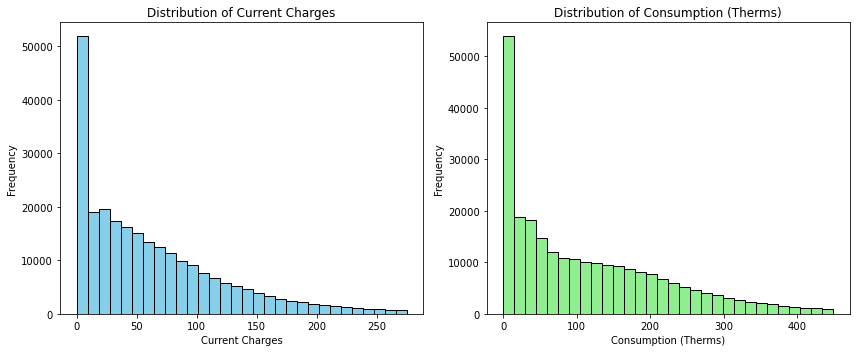

       Development Name   Borough Meter AMR Meter Scope Funding Source  \
1             ALBANY II  BROOKLYN       AMR         NaN        FEDERAL   
3                ALBANY  BROOKLYN       AMR         NaN        FEDERAL   
4                ALBANY  BROOKLYN       AMR         NaN        FEDERAL   
5                ALBANY  BROOKLYN       AMR         NaN        FEDERAL   
6                ALBANY  BROOKLYN       AMR         NaN        FEDERAL   
...                 ...       ...       ...         ...            ...   
628159  WYCKOFF GARDENS  BROOKLYN       AMR         NaN        FEDERAL   
628165  WYCKOFF GARDENS  BROOKLYN       AMR         NaN        FEDERAL   
628171  WYCKOFF GARDENS  BROOKLYN       AMR         NaN        FEDERAL   
628177  WYCKOFF GARDENS  BROOKLYN       AMR         NaN        FEDERAL   
628183  WYCKOFF GARDENS  BROOKLYN       AMR         NaN        FEDERAL   

              Vendor Name            Revenue Month Service Start Date  \
1       National Grid NYC  2020-01-01T

/home/kaan/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


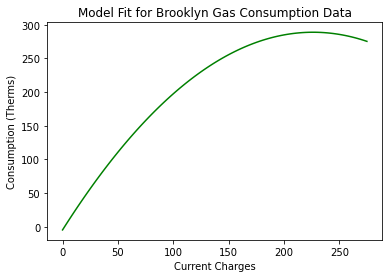

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def mean_square_error(y_true, y_pred):
    """
    Calculate the mean square error of a regression model.

    Parameters:
    y_true (array-like): True values for the target variable.
    y_pred (array-like): Predicted values for the target variable.

    Returns:
    float: Mean square error of the model.
    """
    return np.mean((y_true - y_pred) ** 2)

# Load the data
df = pd.read_csv('GasConsumption.csv', low_memory=False) # Replace with the actual path to your CSV file

# Drop irrelevant columns
df.drop(['TDS #', 'EDP', 'RC Code', 'AMP #', 'UMIS BILL ID', 'Meter Number', 'Account Name', 'Location'], axis=1, inplace=True)

# Filter for rows where 'Borough' is 'BROOKLYN'
brooklyn_df = df.loc[df['Borough'] == 'BROOKLYN'].copy()

# Convert 'Current Charges' and 'Consumption (Therms)' to numeric
brooklyn_df['Current Charges'] = pd.to_numeric(brooklyn_df['Current Charges'], errors='coerce').astype(np.float64)
brooklyn_df['Consumption (Therms)'] = pd.to_numeric(brooklyn_df['Consumption (Therms)'], errors='coerce').astype(np.float64)

# Drop rows with NaN values
brooklyn_df = brooklyn_df.loc[(brooklyn_df['Current Charges'] >= 0) & (brooklyn_df['Consumption (Therms)'] >= 0)].copy()

# Define a function to remove outliers based on the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers
brooklyn_df = remove_outliers(brooklyn_df, 'Current Charges')
brooklyn_df = remove_outliers(brooklyn_df, 'Consumption (Therms)')

# Remove rows with negative values
brooklyn_df = brooklyn_df.loc[(brooklyn_df['Current Charges'] >= 0) & (brooklyn_df['Consumption (Therms)'] >= 0)]

# Plotting the distribution of 'Current Charges' and 'Consumption (Therms)'
plt.figure(figsize=(12, 5))

# Distribution of 'Current Charges'
plt.subplot(1, 2, 1)
plt.hist(brooklyn_df['Current Charges'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Current Charges')
plt.xlabel('Current Charges')
plt.ylabel('Frequency')

# Distribution of 'Consumption (Therms)'
plt.subplot(1, 2, 2)
plt.hist(brooklyn_df['Consumption (Therms)'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Consumption (Therms)')
plt.xlabel('Consumption (Therms)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Prepare the data
X = brooklyn_df[['Current Charges']] # Features
y = brooklyn_df['Consumption (Therms)'] # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with Polynomial Features and Linear Regression
model = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2)), # Add polynomial features
    ('regressor', LinearRegression())
])

# Train the model with the original target
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# print(brooklyn_df['Current Charges'].describe())

print(brooklyn_df)

# Calculate the MSE and print R-squared
mse = mean_square_error(y_test, y_pred)
r_squared = model.score(X_test, y_test)
print(f'Mean Squared Error: {mse}')
print(f"R-squared: {r_squared}")

# Get the model's coefficients and intercept from the 'regressor' step of the pipeline
regressor = model.named_steps['regressor']
print("Coefficients:", regressor.coef_)
print("Intercept:", regressor.intercept_)

# Generate predictions for plotting
X_min, X_max = X['Current Charges'].min(), X['Current Charges'].max()
X_plot = np.linspace(X_min, X_max, 100).reshape(-1, 1)
y_plot = model.predict(X_plot)

# Plot the results
# plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Training data')
# plt.scatter(X_test, y_test, color='red', alpha=0.5, label='Test data')
plt.plot(X_plot, y_plot, color='green', label='Model Prediction')
plt.xlabel('Current Charges')
plt.ylabel('Consumption (Therms)')
plt.title('Model Fit for Brooklyn Gas Consumption Data')
plt.show()